# Call API (basic code blick to run RadQNLI API)

In [ ]:
!pip install -q openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.5 MB/s eta 0:00:00


In [ ]:
import openai
from openai import OpenAI
import time

def RadQNLI(text, n=3):
  max_tries = 3
  for try_number in range(max_tries):
    try:
      completion = client.chat.completions.create(
        model="gpt-3.5-turbo", # gpt-3.5-turbo gpt-4-turbo
        messages=[
              {"role": "system", "content": "You are a helpful assistant that process text and correct grammar."},
              # {"role": "user", "content": "Please correct the grammar of the text below and provide {} rephrased versions of it: '{}' Response format as 'Corrected: ... Rephrased 1: ... Rephrased 2: ... Rephrased 3: ... ...'".format(n, text)}
              {"role": "user", "content": "Please correct the grammar of the text below: {}".format(text)}
          ]
      )
      return completion.choices[0].message.content

    except openai.APIError as e:
      if try_number == max_tries - 1:
        print('APIError: {}'.format(e))
        return '\n'
      else:
        time.sleep(0.1)

In [ ]:
openai.api_key = 'sk- your key'
# text = "It was abnormally upregulated in prostate cancer tissues compared with controls.46 , 47 Lentivirus - mediated overexpression of MCM3AP - AS1 promoted the proliferation , invasion , and migration , while suppressing the apoptosis of PCa cells . "
ans = RadQNLI('hello, i hahah', 3)
print(ans)

Hello, I hahah.


# RadQNLI (classification tasks)

## Install

In [ ]:
!pip install -q openai
!pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 2.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import os
import openai
import concurrent.futures
from tqdm import tqdm
import time
import evaluate

## Prompt

In [ ]:
qa = pd.read_csv('/content/drive/MyDrive/CAID/Data/bio_text/RadQA/radqa_test_balanced.csv')
qa.tail(10)

In [ ]:
messages=[
              {"role": "system", "content": "You are a radiologist. Your task is to determine whether a given context sentence from radiology reports contains the answer to a provided question. Please respond only with 'entailment' or 'not entailment' without any additional explanations."},
              {"role": "user", "content": "Determine whether the given context sentence from radiology reports contains the answer to the provided question.\n\nContext sentence: There is no pleural effusion or pneumothorax.\nQuestion: Are there signs of pneumothorax?"},
              {"role": "assistant", "content": "entailment"},
              {"role": "user", "content": "Determine whether the given context sentence from radiology reports contains the answer to the provided question.\n\nContext sentence: In the region of the subsegmental branch in the right lower lobe there is a suggestion of filling defect that is of uncertain significance.\nQuestion: Is there any evidence of bleeding in the chest cavity?"},
              {"role": "assistant", "content": "not entailment"},
              {"role": "user", "content": "Determine whether the given context sentence from radiology reports contains the answer to the provided question.\n\nContext sentence: No evidence of pneumothorax or other complications.\nQuestion: Do we see any trauma to the pluera due to Central venous line?"},
              {"role": "assistant", "content": "entailment"},
              {"role": "user", "content": "Determine whether the given context sentence from radiology reports contains the answer to the provided question.\n\nContext sentence: {}\nQuestion: {}".format(sentence, question)}
          ]

In [ ]:
messages=[
              {"role": "system", "content": "You are a radiologist. Your task is to determine whether a given context sentence from a radiology report contains the answer to a provided question. Please explain your reasoning first, then answer with either 'Contain' or 'Not contain' on a new line."},
              {"role": "user", "content": "Determine whether the given context sentence from radiology reports contains the answer to the provided question.\n\nContext sentence: There is no pleural effusion or pneumothorax.\nQuestion: Are there signs of pneumothorax?"},
              {"role": "assistant", "content": "entailment"},
              {"role": "user", "content": "Determine whether the given context sentence from radiology reports contains the answer to the provided question.\n\nContext sentence: In the region of the subsegmental branch in the right lower lobe there is a suggestion of filling defect that is of uncertain significance.\nQuestion: Is there any evidence of bleeding in the chest cavity?"},
              {"role": "assistant", "content": "not entailment"},
              {"role": "user", "content": "Determine whether the given context sentence from radiology reports contains the answer to the provided question.\n\nContext sentence: No evidence of pneumothorax or other complications.\nQuestion: Do we see any trauma to the pluera due to Central venous line?"},
              {"role": "assistant", "content": "entailment"},
              {"role": "user", "content": "Determine whether the given context sentence from radiology reports contains the answer to the provided question.\n\nContext sentence: {}\nQuestion: {}".format(sentence, question)}
          ]

In [ ]:
def RadQNLI(sentence, question):
  max_tries = 3
  for try_number in range(max_tries):
    try:
      completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
              {"role": "system", "content": "You are a radiologist. Your task is to determine whether a given context sentence from radiology reports contains the answer to a provided question. Please respond only with 'entailment' or 'not entailment' without any additional explanations."},
              {"role": "user", "content": "Determine whether the given context sentence from radiology reports contains the answer to the provided question.\n\nContext sentence: There is no pleural effusion or pneumothorax.\nQuestion: Are there signs of pneumothorax?"},
              {"role": "assistant", "content": "entailment"},
              {"role": "user", "content": "Determine whether the given context sentence from radiology reports contains the answer to the provided question.\n\nContext sentence: In the region of the subsegmental branch in the right lower lobe there is a suggestion of filling defect that is of uncertain significance.\nQuestion: Is there any evidence of bleeding in the chest cavity?"},
              {"role": "assistant", "content": "not entailment"},
              {"role": "user", "content": "Determine whether the given context sentence from radiology reports contains the answer to the provided question.\n\nContext sentence: No evidence of pneumothorax or other complications.\nQuestion: Do we see any trauma to the pluera due to Central venous line?"},
              {"role": "assistant", "content": "entailment"},
              {"role": "user", "content": "Determine whether the given context sentence from radiology reports contains the answer to the provided question.\n\nContext sentence: {}\nQuestion: {}".format(sentence, question)}
          ]
      )
      return completion.choices[0].message.content

    except openai.APIError as e:
      if try_number == max_tries - 1:
        print('APIError: {}'.format(e))
        return '\n'
      else:
        time.sleep(0.1)

In [ ]:
for i in range(5):
  openai.api_key = 'sk-'
  sentence = "No suspicious lytic or sclerotic osseous lesions are identified."
  question = "Is there any abnormal fluid filled mass in the abdomen?"
  ans = RadQNLI(sentence, question)
  print(ans)
  print('\n')

not entailment


not entailment


not entailment


not entailment


not entailment




## Run

In [ ]:
def process_row(args):
    index, row = args
    corrected_text = RadQNLI(row['sentence'], row['question']).replace('not ', 'not_').replace('.', '')
    return index, corrected_text

openai.api_key = 'sk- your key' # gpt 3.5

input_file = "/content/drive/MyDrive/CAID/Data/bio_text/RadQA/radqa_test_balanced.csv"
df = pd.read_csv(input_file)

# parallel (set max worker to 1 or 2 or 3 if use GPT-4, as GPT-4 has lower rate limit: max 200 call or 4000 tokens per min)
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = dict(tqdm(executor.map(process_row, df.iterrows()), total=len(df)))

# same order as the input
df['predict'] = df.index.map(results.get)

output_file = "/content/drive/MyDrive/CAID/Data/bio_text/RadQA/predict_v3.csv"
df.to_csv(output_file, index=False)

100%|██████████| 920/920 [00:42<00:00, 21.60it/s]


## Eval

In [ ]:
output_file = "/content/drive/MyDrive/CAID/Data/bio_text/RadQA/previous/predict_gpt4.csv"

predict = pd.read_csv(output_file)
# predict['predict'] = predict['predict'].str.replace('Entailment', 'entailment', regex=True)
predict[['label', 'predict']].head(10)

,label,predict
0,not_entailment,not_entailment
1,not_entailment,entailment
2,not_entailment,not_entailment
3,entailment,entailment
4,not_entailment,not_entailment
5,entailment,entailment
6,entailment,entailment
7,not_entailment,not_entailment
8,not_entailment,not_entailment
9,not_entailment,not_entailment


In [ ]:
predict['predict'].unique()

array(['not_entailment', 'entailment'], dtype=object)

In [ ]:
predict['predict'] = predict['predict'].str.replace('Not ', 'not_')
predict['predict'] = predict['predict'].str.replace(' ', '')
# predict['predict'] = predict['predict'].str.replace('2', 'entailment') # alpaca
predict['predict'].unique()

array(['not_entailment', 'entailment'], dtype=object)

In [ ]:
predict['label'] = predict['label'].replace('not_entailment', 1).replace('entailment', 0)
predict['predict'] = predict['predict'].replace('not_entailment', 1).replace('entailment', 0)

ACC = evaluate.load("accuracy")
P = evaluate.load("precision")
R = evaluate.load("recall")
F1 = evaluate.load("f1")
acc = ACC.compute(predictions=predict['predict'], references=predict['label'])
p = P.compute(predictions=predict['predict'], references=predict['label'])
r = R.compute(predictions=predict['predict'], references=predict['label'])
f1 = F1.compute(predictions=predict['predict'], references=predict['label'])
print('ACC: {:0.4f}'.format(acc['accuracy']))
print('P: {:0.4f}'.format(p['precision']))
print('R: {:0.4f}'.format(r['recall']))
print('F1: {:0.4f}'.format(f1['f1']))

ACC: 0.7891
P: 0.9080
R: 0.6435
F1: 0.7532


## plt

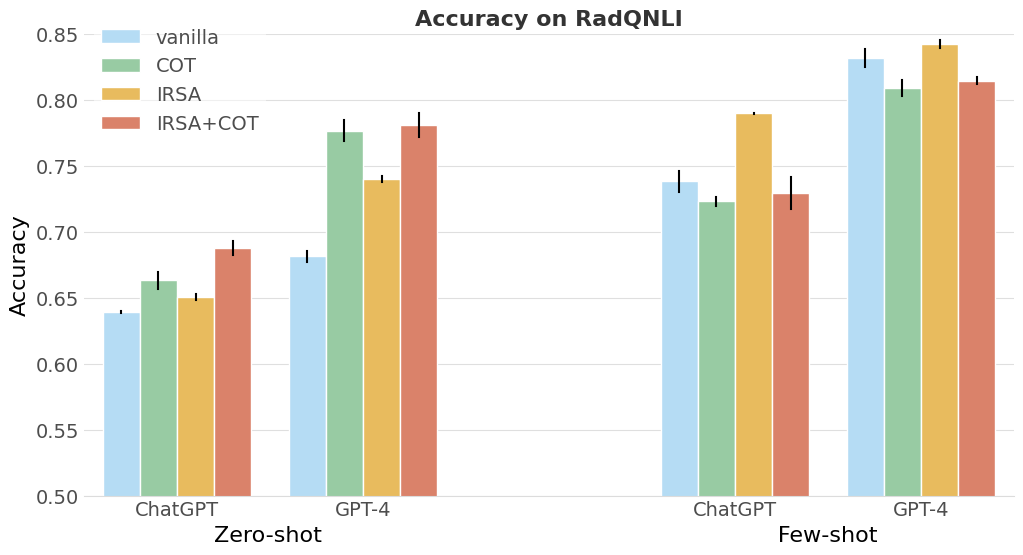

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps

# Data
zero_GPT3_con = [0.6489, 0.6530, 0.6499]
zero_GPT3_concot = [0.6817, 0.6919, 0.6888]
zero_GPT3_ent = [0.6397, 0.6387, 0.6387]
zero_GPT3_entcot = [0.6561, 0.6684, 0.6653]

zero_GPT4_con = [0.7380, 0.7390, 0.7421]
zero_GPT4_concot = [0.7707, 0.7881, 0.7840]
zero_GPT4_ent = [0.6766, 0.6827, 0.6847]
zero_GPT4_entcot = [0.7748, 0.7851, 0.7697]

blank_GPT_con = [0,0,0]
blank_GPT_concot = [0,0,0]
blank_GPT_ent = [0,0,0]
blank_GPT_entcot = [0,0,0]


few_GPT3_con = [0.7902, 0.7892, 0.7892]
few_GPT3_concot = [0.7206, 0.7431, 0.7247]
few_GPT3_ent = [0.7380, 0.7298, 0.7462]
few_GPT3_entcot = [0.7216, 0.7267, 0.7206]

few_GPT4_con = [0.8393, 0.8454, 0.8414]
few_GPT4_concot = [0.8117, 0.8168, 0.8147]
few_GPT4_ent = [0.8250, 0.8311, 0.8383]
few_GPT4_entcot = [0.8086, 0.8025, 0.8147]

# Create a DataFrame
data = pd.DataFrame({
    'zero_ChatGPT_IRSA': zero_GPT3_con,
    'zero_ChatGPT_IRSA+COT': zero_GPT3_concot,
    'zero_ChatGPT_vanilla': zero_GPT3_ent,
    'zero_ChatGPT_COT': zero_GPT3_entcot,
    'zero_GPT-4_IRSA': zero_GPT4_con,
    'zero_GPT-4_IRSA+COT': zero_GPT4_concot,
    'zero_GPT-4_vanilla': zero_GPT4_ent,
    'zero_GPT-4_COT': zero_GPT4_entcot,
    'blank_GPT_IRSA': blank_GPT_con,
    'blank_GPT_IRSA+COT': blank_GPT_concot,
    'blank_GPT_vanilla': blank_GPT_ent,
    'blank_GPT_COT': blank_GPT_entcot,
    'few_ChatGPT_IRSA': few_GPT3_con,
    'few_ChatGPT_IRSA+COT': few_GPT3_concot,
    'few_ChatGPT_vanilla': few_GPT3_ent,
    'few_ChatGPT_COT': few_GPT3_entcot,
    'few_GPT-4_IRSA': few_GPT4_con,
    'few_GPT-4_IRSA+COT': few_GPT4_concot,
    'few_GPT-4_vanilla': few_GPT4_ent,
    'few_GPT-4_COT': few_GPT4_entcot
})

# Melt the DataFrame to a long format suitable for Seaborn's barplot
data = data.melt(var_name='Subgroup', value_name='Value')

# Add Group and Age_Height columns
data['Model group'] = data['Subgroup'].apply(lambda x: 'zero_ChatGPT' if 'zero_ChatGPT' in x else ('zero_GPT-4' if 'zero_GPT-4' in x else ('blank_GPT' if 'blank_GPT' in x else ('few_ChatGPT' if 'few_ChatGPT' in x else 'few_GPT-4'))))
data['setting'] = data['Subgroup'].apply(lambda x: x.split('_')[2])

subgroup_order = ['vanilla','COT','IRSA','IRSA+COT']

# Define custom colors for each bar
cmap = colormaps.get_cmap('tab20')
custom_colors = {
    'vanilla': '#aadfff',
    'COT': '#8fd49e',
    'IRSA': '#ffc347',
    'IRSA+COT': '#ed7857'
}

# Create the barplot with error bars as standard deviation
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Model group', y='Value', hue='setting', hue_order=subgroup_order,  palette=custom_colors, data=data, errorbar='sd', errcolor = 'black', errwidth = 1.5, edgecolor = 'w') # capsize

ax.grid(which='major', axis='y', alpha=0.4)
ax.set_axisbelow(True)
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('gainsboro')

ax.set_ylim([0.5, 0.85])

# ax.set_ylabel('')
# ax.set_yticklabels([])

ax.set_xticklabels(['ChatGPT', 'GPT-4', '', 'ChatGPT', 'GPT-4'], c='0.3', fontsize=14)
ax.set_xlabel('Zero-shot                                                                Few-shot ', fontsize=16) # fontweight='bold', color='black'
ax.tick_params(length=0, axis='x')
ax.tick_params(axis='y', colors='0.3', length=0, labelsize=14)

legend = ax.legend(loc='upper left', framealpha=0.5, fontsize=14, bbox_to_anchor= (0, 1.05))
legend.get_frame().set_linewidth(0.0)
for text in legend.get_texts():
    text.set_color('0.3')

plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy on RadQNLI', fontsize=16, fontweight='bold', c='0.2')
# plt.savefig('acc.jpg', bbox_inches='tight', pad_inches=0.1, dpi=1200)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Accuracy data
accuracy1 = [0.4708, 0.5619, 0.7185, 0.7408, 0.8280]
accuracy2 = [0.4719, 0.5589, 0.7236, 0.7574, 0.8414]
accuracy3 = [0.4708, 0.5803, 0.7400, 0.7615, 0.8465]
accuracy4 = [0.5824, 0.6407, 0.7421, 0.7697, 0.8557]
accuracy5 = [0.5947, 0.6479, 0.7584, 0.7738, 0.8618]

x_values = [10, 30, 100, 200, 350]
x_labels = ['10', '100', '500', '1000', '7911']

fig, ax = plt.subplots()

plt.plot(x_values, accuracy1, color='tab:blue', marker='o', markersize=4, label='DistilBERT', linewidth=1)
plt.plot(x_values, accuracy2, color='tab:orange', marker='o', markersize=4, label='BERT', linewidth=1)
plt.plot(x_values, accuracy3, color='tab:green', marker='o', markersize=4, label='RoBERTa', linewidth=1)
plt.plot(x_values, accuracy4, color='tab:red', marker='o', markersize=4, label='BioBERT', linewidth=1)
plt.plot(x_values, accuracy5, color='tab:purple', marker='o', markersize=4, label='ClinicalBERT', linewidth=1)


plt.axhline(y=0.7895, linestyle='--', color='0', linewidth=1)
plt.axhline(y=0.8420, linestyle='--', color='0', linewidth=1)

plt.axhline(y=0.6875, linestyle='--', color='0.5', linewidth=1)
plt.axhline(y=0.7809, linestyle='--', color='0.5', linewidth=1)


plt.text(4, 0.7895+0.003, '10-shot ChatGPT', fontsize=10, color='0')
plt.text(4, 0.8420+0.003, '10-shot GPT-4', fontsize=10, color='0')

plt.text(275, 0.6875-0.016, '0-shot ChatGPT', fontsize=10, color='0')
plt.text(290, 0.7809-0.016, '0-shot GPT-4', fontsize=10, color='0')

ax.grid(alpha=0.1)
ax.set_axisbelow(True)
ax.spines['left'].set_color('gainsboro')
ax.spines['right'].set_color('gainsboro')
ax.spines['top'].set_color('gainsboro')
ax.spines['bottom'].set_color('gainsboro')

ax.tick_params(length=0, axis='x')
ax.tick_params(axis='y', colors='0.3', length=0)
ax.tick_params(axis='x', colors='0.3', length=0)


# plt.legend(loc='upper left')
legend = plt.legend(loc='lower right', framealpha=1)
# legend.get_frame().set_linewidth(0.0)
for text in legend.get_texts():
    text.set_color('0.3')


plt.xticks(x_values, x_labels)

plt.title('Comparsion between GPT and fine-tuned models', c='0.2', fontsize=12)
plt.xlabel('# of samples in training', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
# plt.gcf().set_size_inches(6.4, 4.8)
plt.savefig('GPT_BERT.jpg', bbox_inches='tight', pad_inches=0.1, dpi=1200)
plt.show()

In [ ]:
import numpy as np

print("zero_GPT3_ent: mean={:0.4f}  std={:0.4f}".format(np.mean(zero_GPT3_ent), np.std(zero_GPT3_ent)))
print("zero_GPT3_entcot: mean={:0.4f}  std={:0.4f}".format(np.mean(zero_GPT3_entcot), np.std(zero_GPT3_entcot)))
print("zero_GPT3_con: mean={:0.4f}  std={:0.4f}".format(np.mean(zero_GPT3_con), np.std(zero_GPT3_con)))
print("zero_GPT3_concot: mean={:0.4f}  std={:0.4f}".format(np.mean(zero_GPT3_concot), np.std(zero_GPT3_concot)))
print('\n')
print("zero_GPT4_ent: mean={:0.4f}  std={:0.4f}".format(np.mean(zero_GPT4_ent), np.std(zero_GPT4_ent)))
print("zero_GPT4_entcot: mean={:0.4f}  std={:0.4f}".format(np.mean(zero_GPT4_entcot), np.std(zero_GPT4_entcot)))
print("zero_GPT4_con: mean={:0.4f}  std={:0.4f}".format(np.mean(zero_GPT4_con), np.std(zero_GPT4_con)))
print("zero_GPT4_concot: mean={:0.4f}  std={:0.4f}".format(np.mean(zero_GPT4_concot), np.std(zero_GPT4_concot)))
print('\n')
print("few_GPT3_ent: mean={:0.4f}  std={:0.4f}".format(np.mean(few_GPT3_ent), np.std(few_GPT3_ent)))
print("few_GPT3_entcot: mean={:0.4f}  std={:0.4f}".format(np.mean(few_GPT3_entcot), np.std(few_GPT3_entcot)))
print("few_GPT3_con: mean={:0.4f}  std={:0.4f}".format(np.mean(few_GPT3_con), np.std(few_GPT3_con)))
print("few_GPT3_concot: mean={:0.4f}  std={:0.4f}".format(np.mean(few_GPT3_concot), np.std(few_GPT3_concot)))
print('\n')
print("few_GPT4_ent: mean={:0.4f}  std={:0.4f}".format(np.mean(few_GPT4_ent), np.std(few_GPT4_ent)))
print("few_GPT4_entcot: mean={:0.4f}  std={:0.4f}".format(np.mean(few_GPT4_entcot), np.std(few_GPT4_entcot)))
print("few_GPT4_con: mean={:0.4f}  std={:0.4f}".format(np.mean(few_GPT4_con), np.std(few_GPT4_con)))
print("few_GPT4_concot: mean={:0.4f}  std={:0.4f}".format(np.mean(few_GPT4_concot), np.std(few_GPT4_concot)))

zero_GPT3_ent: mean=0.6390  std=0.0005
zero_GPT3_entcot: mean=0.6633  std=0.0052
zero_GPT3_con: mean=0.6506  std=0.0017
zero_GPT3_concot: mean=0.6875  std=0.0043


zero_GPT4_ent: mean=0.6813  std=0.0034
zero_GPT4_entcot: mean=0.7765  std=0.0064
zero_GPT4_con: mean=0.7397  std=0.0017
zero_GPT4_concot: mean=0.7809  std=0.0074


few_GPT3_ent: mean=0.7380  std=0.0067
few_GPT3_entcot: mean=0.7230  std=0.0027
few_GPT3_con: mean=0.7895  std=0.0005
few_GPT3_concot: mean=0.7295  std=0.0098


few_GPT4_ent: mean=0.8315  std=0.0054
few_GPT4_entcot: mean=0.8086  std=0.0050
few_GPT4_con: mean=0.8420  std=0.0025
few_GPT4_concot: mean=0.8144  std=0.0021
